In [1]:
# Function to take a folder path, load the behavioral and licking data. Clean it to a nice lil pandas df
def load_beh_data(path, animal_id):

    import os 
    import pandas as pd
    import numpy as np

    file_pandas = animal_id + "_df.csv"
    if os.path.isfile(file_pandas):
        beh_df = pd.read_csv(file_pandas)
    else:
    
        file_data = 'analyze_animal_'+animal_id+'.mat'
        data_path = os.path.join(path,file_data)

        beh_data = import_matlab_file(data_path)
        beh_df, ignore = pd_from_uneven_dict(beh_data['animal'])
        beh_df = beh_df.rename(columns={"lick_0": "RH", "lick_1": "LH", "lick_2": "RM", "lick_3": "LM", "lick_4": "NG"})

        boo_cols = ["RH", "LH", "RM", "LM", "NG", "LED"]
        beh_df[boo_cols] = beh_df[boo_cols].astype(bool)


        # file_ttl = 'ttl_info_'+animal_id+'.mat'
        # ttl_path = os.path.join(path, file_ttl)
        # ttl_data = import_matlab_file(ttl_path)

        # beh_df['Spout_1']= np.mean(ttl_data['trial_info']['lick'][:,750:825,0],axis = 1)
        # beh_df['Spout_2'] = np.mean(ttl_data['trial_info']['lick'][:,750:825,1],axis = 1)


        file_ttl2 = 'ttl_choices_'+animal_id+'.mat'
        ttl_path2 = os.path.join(path, file_ttl2)
        ttl_data2 = import_matlab_file(ttl_path2)
        c = ttl_data2['trial_info']['choice'][:,:,750:1750]
        beh_df['latency'] = determine_latency(beh_df['rxnTime'], c)

        beh_df.to_csv(file_pandas, index= False)
        

    return beh_df

In [2]:
# Function that infers the latency of a response from the lick rasters
def determine_latency(rxn, c):
    import numpy as np
    rx = []
    for a in range(c.shape[0]):
        r = (np.argwhere(c[a,:,:]== 1))

        if r.size == 0 and rxn[a] > 0:
            rx.append(rxn[a]);
        elif r.size == 0:
            rx.append(np.nan)
            #ch.append(np.nan)
        else:
            #ch.append(r[0][0])
            rx.append(r[0][1])

    return rx

In [3]:
def import_matlab_file(file):
    from scipy.io import loadmat
    
    mat_data = loadmat(file, struct_as_record = False, squeeze_me = True, mat_dtype = True, chars_as_strings = True, simplify_cells = True)
    mat_data =  {k:v for k,v in mat_data.items() if '__' not in k};
    
    return mat_data

In [4]:
# Reorganization of dictionaries into dataframes. Used to clean up my matlab structs into df with rows corresponding to trials
def pd_from_uneven_dict(d):

    import numpy as np
    import pandas as pd
    
    shapes = [v.shape for v in d.values() if len(v.shape) == 1]
    trials = max(shapes)[0]

    single_dim = {k:v for k,v in d.items() if (len(v.shape) == 1)  & (trials == v.shape[0])};
    df = pd.DataFrame(single_dim);

    remainder = {};

    for k,v in d.items():
        
        if len(v.shape)  ==  3:
            split_data = np.dsplit(v, v.shape[2]);
            for ind, dim in enumerate(split_data):
                col_name = k + "_"+f'{ind}';
                if dim.shape[0] == trials:
                    df[col_name] = list(np.squeeze(dim))
                else:
                    df[col_name] = list(np.squeeze(dim.transpose))
        elif len(v.shape) == 2:
            if v.shape[1] == trials:
                v = v.transpose()

            if v.shape[1] < 10:
                for i, j in enumerate(v.transpose()):
                        col_name = k + "_" + f'{i}'
                        
                        df[col_name] = j
            else:
                col_name = k
                df[col_name] = list(np.squeeze(v))
                
        elif (len(v.shape) == 1)  & (trials != v.shape[0]):
            remainder[k] = v;

        
            
    return df, remainder

In [5]:
# function to take beh_df and processes the data into the form for modeling. Keep as a dataframe to 
# allow for easier subsampling of trials. Next steps: incorporate a function that allows for easy sampling
# of trial history
def clean_beh_data(b):
    import numpy as np
    import pandas as pd

    
    b2 = pd.DataFrame()
    ns = np.array(np.append(1, np.diff(b['sessionNum'])), dtype = bool)

    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    pr = np.concatenate(([0], b2['Rightward'][:-1].values));
    pr[ns] = 0;
    b2['Previous_rightward'] = pr;

    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    pc = np.concatenate(([0], b2['Correct'][:-1].values))  
    pc[ns] = 0;
    b2['Previous_correct'] = pc;

    b2['Stimulus'] =np.log2(b['stimulus']/8)/2
    #b2['Stimulus'] =(1/b['stimulus'])
    b2['LED'] = b['LED'].astype(int);
    b2['Target'] = b['target'].astype(int);
    b2['Session'] = b['sessionNum'];

   
    b2['Latency'] = np.log2((1/(b['latency'])*1000)/8)/2;
    #b2['New_session']= ns;
   
    go = ((b['RH'] | b['LM'] | b['RM'] | b['LH']).values) & ((b['latency'] > 0).T).values
    b2 = b2.iloc[go,:]
    
    return b2

In [6]:
def expand_history(d, back):
    import numpy as np
    d = np.expand_dims(d, axis = 1)

    for _ in range(back):
        add = np.r_[0, d[:-1, -1]]
        d = np.c_[d, add]

    return d


In [162]:

import os
#path = os.getcwd();

animal = 'opto_011'

path = r"C:\Users\natet\Desktop\Experimental_Data\CT\opto_011"
import numpy as np

b = load_beh_data(path, animal)
b2 = clean_beh_data(b)
b2.head()

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Rightward,Previous_rightward,Correct,Previous_correct,Stimulus,LED,Target,Session,Latency
97,0,0,1,0,-1.0,0,0,1.0,-0.655170
98,0,0,1,1,1.0,0,0,1.0,-0.604571
99,0,0,1,1,-1.0,0,0,1.0,-1.255987
102,0,0,1,0,1.0,0,0,1.0,-0.591981
103,0,0,1,1,-1.0,0,0,1.0,-1.216480


In [387]:

import numpy as np
rw = np.array(b2['Rightward'])
np.sum(b2['Target'][b2['Stimulus'] > 0])


#b2.head()

14

To do list:
- decide on data input i.e. what stages of training to run analysis on
- write code to iteratively fit each animal by walking through the directories
- EVALUATE THE FITS - ensure the regression is actually fitting the data 

Tasks
- function to generate the inputs to the model
- function to split the data into groups of interest (i.e. LED, no LED, 8 Hz)
- function to run the model, generate score, return coefficients
- second function to run leave on out with each parameter with BIC to determine which weight is most important for the fit
- function to 

In [307]:
def generate_logistics_inputs(b2):
    import numpy as np

  
    previous_choice = expand_history(np.array(b2['Previous_rightward']), 3)
    previous_reward = expand_history(np.array(b2['Previous_correct']),1)
    
    stimulus_direction = np.zeros(b2['Stimulus'].shape);
    stimulus_direction[b2['Stimulus'] < 0] = -1;
    stimulus_direction[b2['Stimulus'] > 0] = 1;
    
    stimulus_magnitude = np.abs(b2['Stimulus'])
    
    #previous_stimulus = expand_history(np.array(b2['Stimulus']),2)
    previous_stimulus = expand_history(stimulus_direction,1)
    latency = np.array(b2['Latency'])

    
    # X = np.c_[np.ones((latency.shape[0], 1)), previous_stimulus, previous_choice, previous_reward, latency]
    #X = np.c_[np.ones((latency.shape[0], 1)), np.array(b2['Stimulus']), latency, np.array(b2['Previous_correct']), previous_choice]
    #X = np.c_[np.ones((latency.shape[0], 1)), latency, np.array(b2['Previous_correct']), previous_choice]
    X = np.c_[np.ones((latency.shape[0], 1)),  previous_stimulus[:,1:],  np.array(b2['Previous_correct']), np.array(b2['Previous_rightward'])]
    y = np.array(b2['Rightward'])
    
    select = np.array(b2)
    
    #labels = ['Bias', 'Stimulus', '1 Stim', '2 Stim', '1 Choice', '2 Choice', '1 Reward', '2 Reward', 'latency']
    #labels = ['Bias', 'Stimulus', 'Latency', 'Previous Reward', 'Previous Choice 1' ,'Previous Choice 2','Previous Choice 3','Previous Choice 4' ]
    #labels = ['Bias',  'Latency', 'Previous Reward', 'Previous Choice 1' ,'Previous Choice 2','Previous Choice 3','Previous Choice 4' ]
    labels = ['Bias',  'Previous Direction',  'Previous Reward', 'Previous Choice 1'  ]

    return X, y, labels

In [298]:
labels = ['Bias', 'Stimulus Magnitude', 'Stimulus Direction', 'Previous Direction', 'Latency', 'Previous Reward', 'Previous Choice 1' ,'Previous Choice 2','Previous Choice 3','Previous Choice 4' ]
b2.head()

,Rightward,Previous_rightward,Correct,Previous_correct,Stimulus,LED,Target,Session,Latency
97,0,0,1,0,-1.0,0,0,1.0,-0.655170
98,0,0,1,1,1.0,0,0,1.0,-0.604571
99,0,0,1,1,-1.0,0,0,1.0,-1.255987
102,0,0,1,0,1.0,0,0,1.0,-0.591981
103,0,0,1,1,-1.0,0,0,1.0,-1.216480


In [299]:
def split_data_inputs(X,y, b2):
    
    l = b2['LED'].astype(bool)
    s = b2['Stimulus'] == 0;
    rX = [X[l ,:] , X[s ,:]]
   
    ry = [y[l] , y[s]]
    
    
    return rX, ry
    
    
    

In [300]:
def fit_logistic(X,y):
    #from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    #rskf = StratifiedKFold(n_splits=5)
    rskf = KFold(n_splits=5, shuffle = True, random_state=50)
    #rskf.get_n_splits(X, y)

    score = []
    coef = []
    for train_index, test_index in rskf.split(X,y):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression().fit(X_train, y_train)
        
     
        
        score.append(clf.score(X_test,y_test))
        coef.append(clf.coef_)
        
    return np.array(score), np.squeeze(np.array(coef))
    

In [301]:
def full_logistic_preprocess(path, animal):

    import os 
    b = load_beh_data(path, animal)

    filep = os.path.join(path,'analyze_training_'+animal+'.mat')
    m2 = import_matlab_file(filep)

    expert = m2['training']['days_expert']
    proficient = m2['training']['days_proficient']
    opto = m2['training']['days_opto']
    b = b[(b['sessionNum'] >= proficient+5) & (b['sessionNum'] < proficient +10) ]#& (b['sessionNum'] > proficient) ]

    b2 = clean_beh_data(b)
    high_side, counts = np.unique(b2['Target'][b2['Stimulus'] > 0], return_counts = True);
    

    
    if high_side[np.argmax(counts)] == 0:
        b2['Rightward'] = (~(b2['Rightward'].astype(bool))).astype(int)
        b2['Previous_rightward'] = (~(b2['Previous_rightward'].astype(bool))).astype(int)

    X,y, labels = generate_logistics_inputs(b2)
    
    
        
    rX, ry = split_data_inputs(X,y,b2)
    
    
    
    
    scores,coefs = zip(*[fit_logistic(a,b) for a,b in zip(rX,ry)])
    
    
    
    return np.vstack(scores), np.dstack(coefs), labels




In [302]:
high_side, counts = np.unique(b2['Target'][b2['Stimulus'] > 0], return_counts = True);
np.argmax(counts)


1

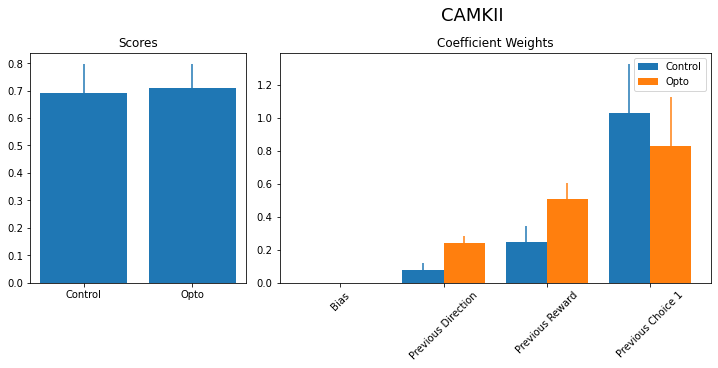

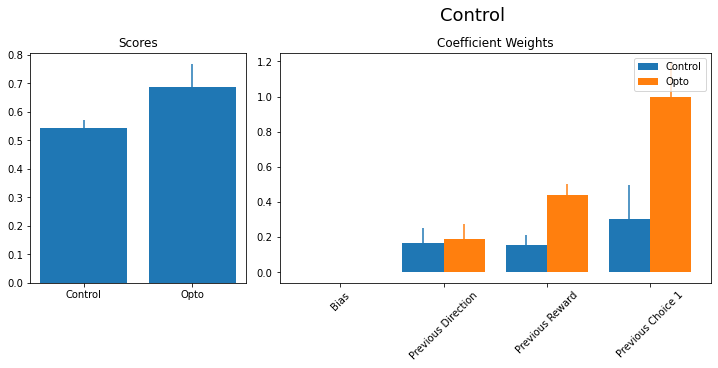

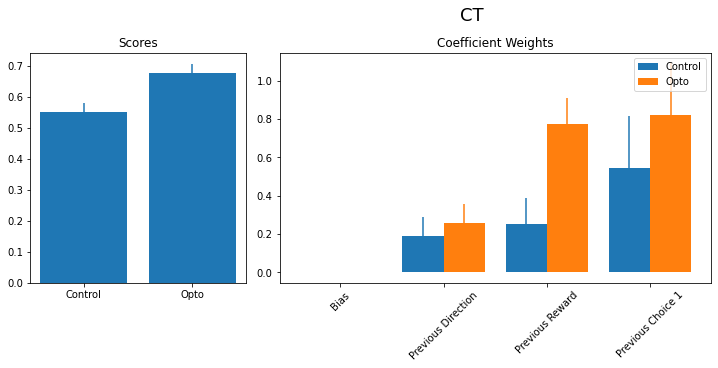

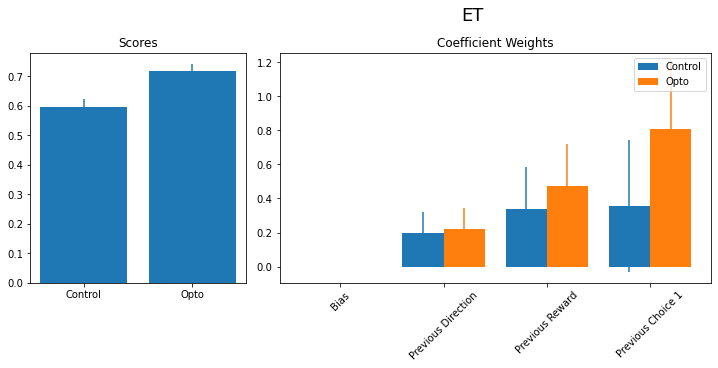

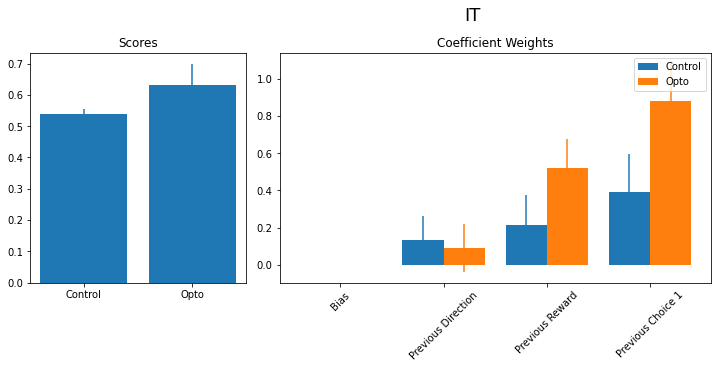

In [308]:
path = r"C:\Users\natet\Desktop\Experimental_Data"

import os
import numpy as np
experimental_groups = os.listdir(path)

for g in experimental_groups:
    
    g_dir = os.path.join(path,g)
    animals = os.listdir(g_dir)
    
    group_scores = []
    group_coefs = []
    
    for a in animals:
        a_dir = os.path.join(path,g,a)
        
        scores, coefs, labels = full_logistic_preprocess(a_dir, a)
        #plot_single_logR(scores, coefs, a)
        group_coefs.append(np.mean(coefs, axis = 0))
        group_scores.append(np.mean(scores, axis = 1))
    
    gs = np.array(group_scores)
    gc = np.array(group_coefs)
    plot_single_logR(gs.T, abs(gc), g)
    
    

                

In [305]:
experimental_groups = os.listdir(path)

for g in experimental_groups:
    g_dir = os.path.join(path,g)
    print(g_dir)
    print(os.listdir(os.path.join(path,g)))
    


C:\Users\natet\Desktop\Experimental_Data\CAMKII
['opto_200', 'opto_209', 'opto_96', 'opto_97']
C:\Users\natet\Desktop\Experimental_Data\Control
['c_129', 'c_136', 'c_137']
C:\Users\natet\Desktop\Experimental_Data\CT
['opto_011', 'opto_016', 'opto_207', 'opto_208']
C:\Users\natet\Desktop\Experimental_Data\ET
['opto_211', 'opto_212', 'opto_69', 'opto_70']
C:\Users\natet\Desktop\Experimental_Data\IT
['opto_203', 'opto_204', 'opto_205', 'opto_206']


In [209]:
len(labels)

10

In [347]:
import seaborn as sns

g = sns.catplot(
    data= coefs, kind="bar",
    x="species", y="body_mass_g", hue="sex",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")

AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [142]:

def plot_single_logR(scores, coefs, a):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    %matplotlib inline

    fig = plt.figure(constrained_layout=True, figsize=(13,5))
    spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
    

    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1:3])


    ax1.bar([1,2],np.mean(scores, axis = 1))

    ax1.errorbar([1,2],np.mean(scores, axis = 1), np.std(scores, axis = 1), ls = '')
    ax1.set_title('Scores')

    ax1.set_xticks([1,2])
    ax1.set_xticklabels(["Control", "Opto"])

    width = 0.40

    ax2.bar(np.arange(len(labels)) - width/2,np.squeeze(np.mean(coefs[:,:,0], axis = 0)), width, label = 'Control')
    ax2.errorbar(np.arange(len(labels)) - width/2,np.squeeze(np.mean(coefs[:,:,0], axis = 0)),np.squeeze(np.std(coefs[:,:,0], axis = 0)), ls = '')

    ax2.bar(np.arange(len(labels)) + width/2,np.squeeze(np.mean(coefs[:,:,1], axis = 0)), width, label = 'Opto')
    ax2.errorbar(np.arange(len(labels)) + width/2,np.squeeze(np.mean(coefs[:,:,1], axis = 0)),np.squeeze(np.std(coefs[:,:,0], axis = 0)), ls = '')

    ax2.set_title('Coefficient Weights')
    ax2.set_xticks(np.arange(len(labels)))
    ax2.set_xticklabels(labels)
    ax2.tick_params(axis='x', labelrotation = 45)
    # ax2.autoscale(tight=True)
    ax2.legend()

    # ax2.bar_label(nl, padding=3)
    # ax2.bar_label(l, padding=3)

    fig.suptitle(a, fontsize = 18)



    plt.show()




In [177]:
scores
gs.T

array([[0.88322579, 0.89818092, 0.86963827, 0.8698141 ],
       [0.74877162, 0.72932542, 0.7119485 , 0.71034247]])

In [17]:
tt

,0,1,2,3,4,5,6,7,8
0,-0.000121,4.236057,0.186240,-0.082194,0.880026,0.643652,-0.252564,-0.042541,0.523950
1,0.000088,2.919957,0.392204,-0.080625,-0.382891,-0.391934,-0.403562,-0.141185,-0.097531
2,0.000070,4.229858,0.040909,-0.275509,0.645517,0.626072,-0.174494,-0.003887,3.814210
3,-0.000136,4.181554,-0.226416,-0.152634,-1.262088,-0.815797,-0.111497,0.152522,-0.124241


In [420]:
(~(y.astype(bool))).astype(int)

107      0
117      0
119      0
121      0
122      0
        ..
11913    1
11914    0
11916    0
11918    0
11922    0
Name: Rightward, Length: 10476, dtype: int32